**Construyendo un proyecto de aprendizaje de máquina**

*Códigos referencia del libro Hands-On Machine Learning with Scikit-Learn and Tensor Flow 2017 (Cap 2) -- Aurélien Géron

# Etapas principales en un sistema de aprendizaje de máquina

1. Observar el problema (ayuda interdisciplinar)
2. Obtener los datos
3. Análisis exploratorio incial (visualizar los datos y estadística descriptiva básica)
4. Preparar los datos para los algoritmos de aprendizaje de máquina (evaluación, preproceso, caracterización, aprendizaje)
5. Seleccionar un modelo y entrenar
6. Sintonizar el modelo escogido
7. Presentar la solución
8. Lanzar la solución, monitorear y mantener el sistema de aprendizaje de máquina.

# Problema a resolver

*Objetivo: predecir precios medios en distritos de California-USA.*

*Insumos: Características de los distritos*

# Inicio códigos

**Preparar modulos principales, funciones inline, paths para guardar archivos y figuras:**

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "imagesAM", CHAPTER_ID)
HOUSING_PATH = "datasets/housing/"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Obtener los datos


In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


# Análisis exploratorio básico

Saving figure attribute_histogram_plots


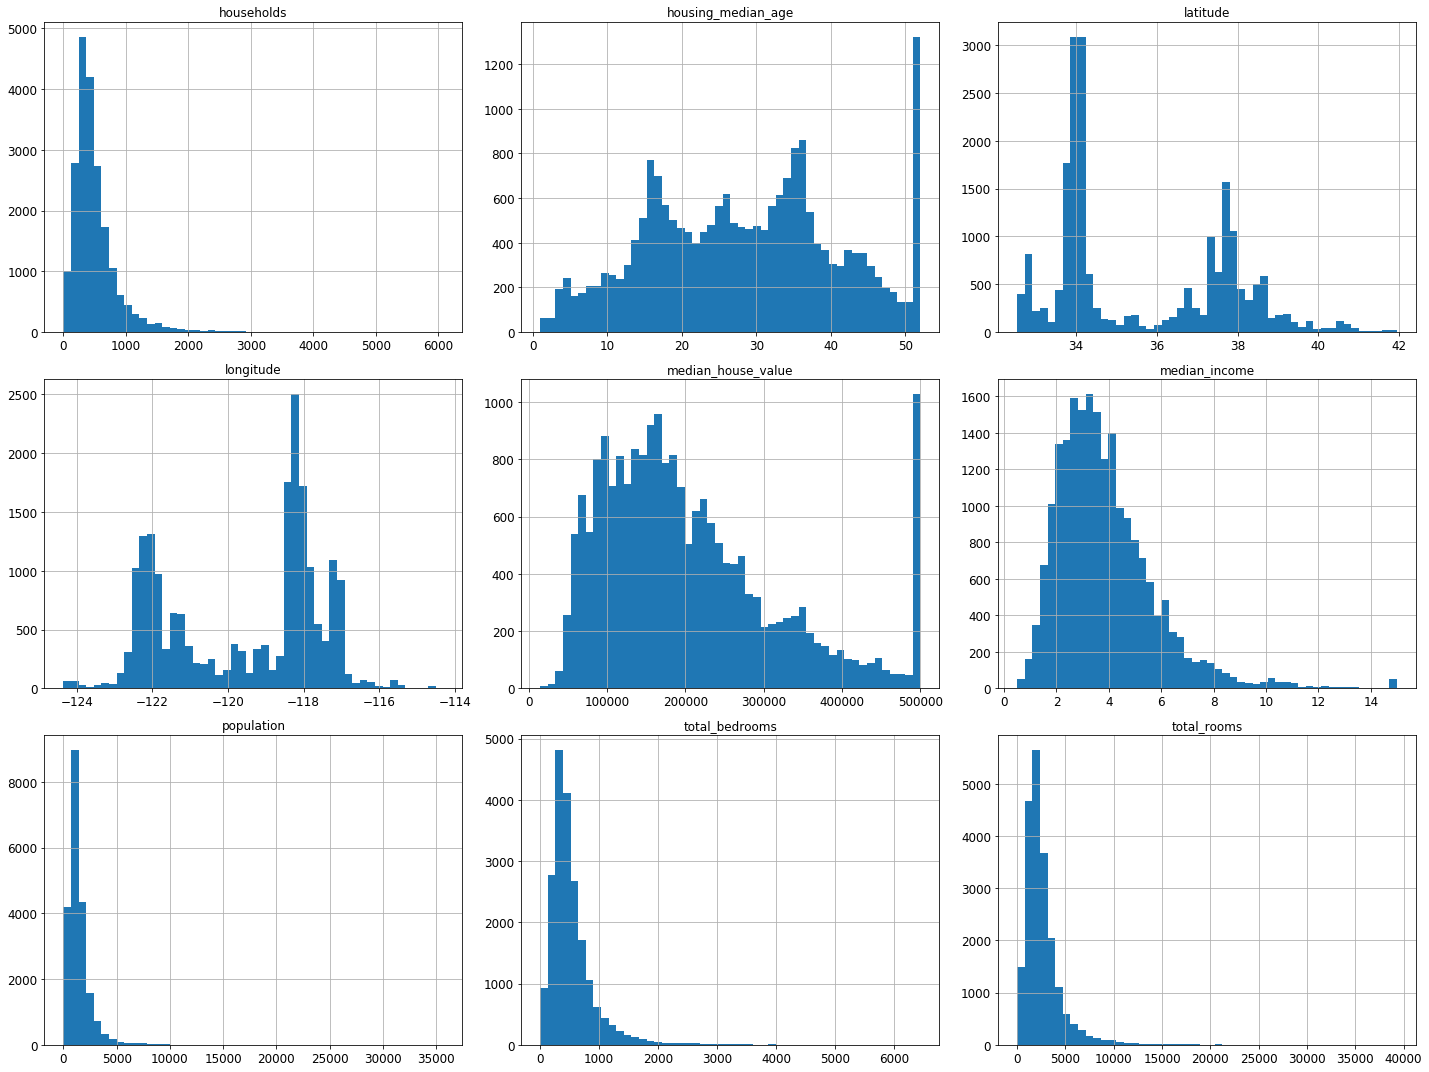

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# Preparar datos (validación y análisis exploratorio por visualización)

In [6]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

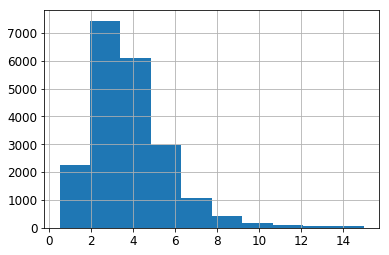

In [7]:
housing["median_income"].hist()

**Preproceso variable median_income -> continua a categórica**

In [8]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [9]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

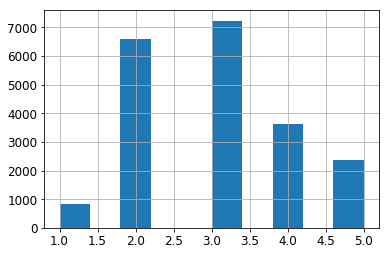

In [10]:
housing["income_cat"].hist()


**Muestreo estratificado de datos: asegurar mismas proporciones en las particiones de datos con base a característica de interés**

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"].values):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [12]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [13]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [14]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

**Comparar errores en particiones con y sin estratificación**

In [15]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [16]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [17]:
for set_ in (strat_train_set, strat_test_set): #remove rows or columns
    set_.drop("income_cat", axis=1, inplace=True)

# Análisis exploratorio y visualización sobre datos muestreados

In [18]:
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


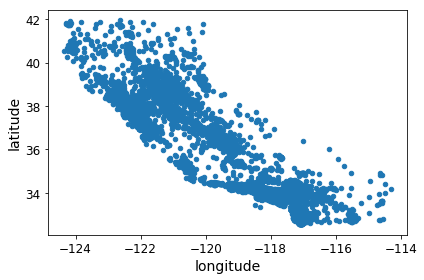

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


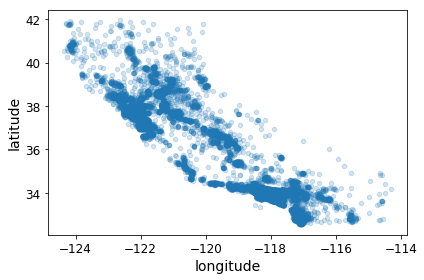

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

Saving figure housing_prices_scatterplot


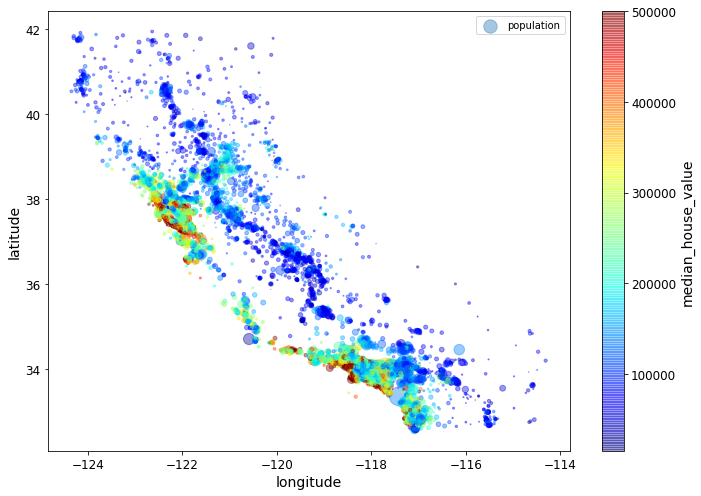

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

Saving figure california_housing_prices_plot


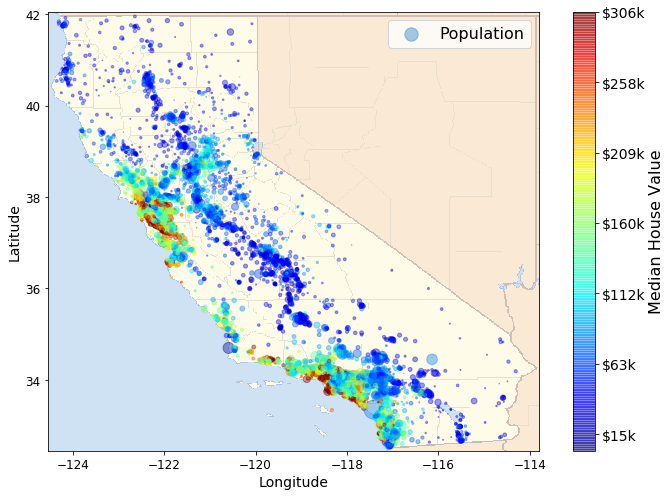

In [22]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/imagesAM/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

**Identificación de correlaciones**

In [23]:
corr_matrix = housing.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1,-0.924478,-0.105848,0.048871,0.0765985,0.10803,0.0630696,-0.0195833,-0.0474324
latitude,-0.924478,1,0.0057661,-0.0391837,-0.0724189,-0.115222,-0.077647,-0.0752054,-0.142724
housing_median_age,-0.105848,0.0057661,1,-0.364509,-0.325047,-0.29871,-0.306428,-0.11136,0.11411
total_rooms,0.048871,-0.0391837,-0.364509,1,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.0765985,-0.0724189,-0.325047,0.929379,1,0.87632,0.98017,-0.00973978,0.0476886
population,0.10803,-0.115222,-0.29871,0.855109,0.87632,1,0.904637,0.00238001,-0.02692
households,0.0630696,-0.077647,-0.306428,0.918392,0.98017,0.904637,1,0.0107813,0.0645063
median_income,-0.0195833,-0.0752054,-0.11136,0.200087,-0.00973978,0.00238001,0.0107813,1,0.68716
median_house_value,-0.0474324,-0.142724,0.11411,0.135097,0.0476886,-0.02692,0.0645063,0.68716,1


Saving figure corr_matrix


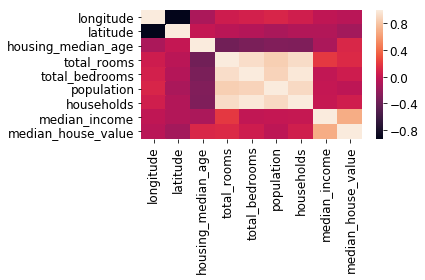

In [24]:
import seaborn as sns
sns.heatmap(corr_matrix,xticklabels=corr_matrix.columns.values,yticklabels=corr_matrix.columns.values)
save_fig("corr_matrix")

In [25]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


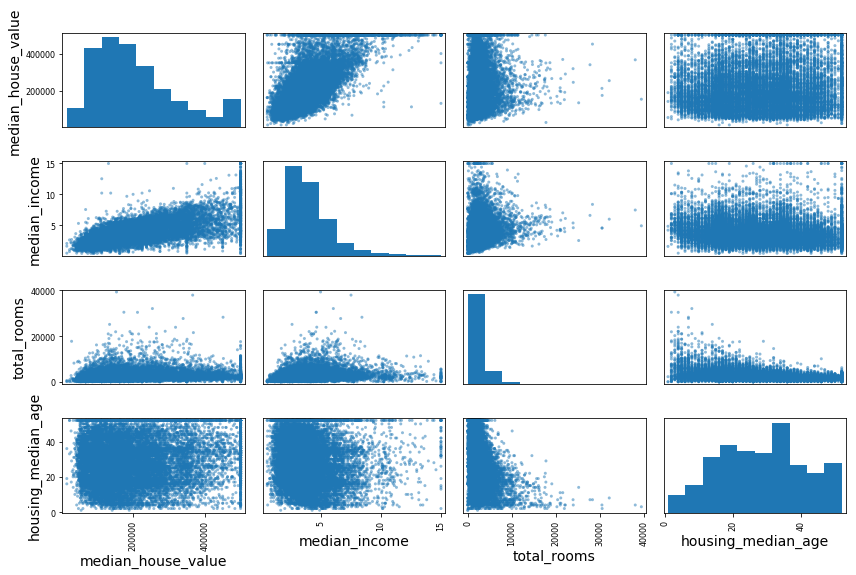

In [26]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


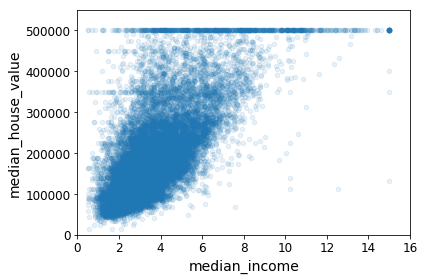

In [27]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

**Generar nuevas características intuitivas**

In [28]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [29]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

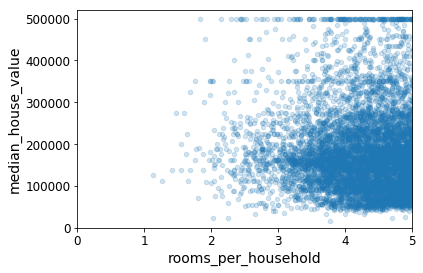

In [30]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [31]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Preparar los datos para los algoritmos de aprendizaje de máquina

In [32]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [33]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


# Opciones básicas para lidiar con datos perdidos

1. Quitar filas (instancias con característica perdida)
2. Quitar columnas (se elimina la característica completa si presenta datos perdidos)
3. Se estiman los valores perdidos mediante mediana, promedio, moda, o estimaciones por vecindario.

In [34]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [35]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [36]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


**Clase Imputer de scikit-learn contiene este preproceso para datos perdidos**

In [37]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

Se deben remover las variables nominales para aplicar la opción por mediana:

In [38]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [39]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [40]:
imputer.statistics_ #valores obtenidos en preproceso imputer por atributo numérico

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Dichos valores son las mismas medianas:

In [41]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Aplicar el preproceso (transformación) según lo entrenado con imputer:

In [42]:
X = imputer.transform(housing_num)

In [43]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [44]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [45]:
imputer.strategy

'median'

In [46]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


# Cómo trabajar con variables nominales (categóricas)? (ej: 'ocean_proximity')

1. Etiquetar (codificar) los textos. Problemas: la noción de cercanía pierde sentido
2. One-hot-encoding, una nueva característica binaria se genera por cada categoría de la variable de interés. Problema: el número de características crece considerablemente.

In [47]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [48]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [49]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [50]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [51]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Por defecto, la clase `OneHotEncoder` retorna un arreglo ralo (sparse), se puede usar la función `toarray()` para trabajar con arreglos completos (full).

In [52]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

También se puede fijar la opción  `sparse=False` en `OneHotEncoder`:

In [53]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [54]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Let's create a custom transformer to add extra attributes:

In [55]:
from sklearn.preprocessing import FunctionTransformer

rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]


def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [56]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


# Esquema general (pipeline) de preproceso para atributos numéricos

1. Lidiar con datos perdidos -> SimpleImputer
2. Añadir nuevos atributos desde conocimiento a priori (equipo interdisciplinar) -> FunctionTransformer
3. Escalado de atributos (min max ; estandarización - zscore). Min-max sensible a atípicos  

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()), #MinMaxScaler StandardScaler
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_labels=stats.zscore(housing_labels)

Un esquema general, incluyendo atributos numéricos y categóricos se puede generar con la clase `ColumnTransformer`

In [58]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [59]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs), #OneHotEncoder or OrdinalEncoder()
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [60]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [61]:
housing_prepared.shape

(16512, 16)

# Seleccionar un modelo y entrenar sobre los datos preparados,Sintonizar parametros

# Regresión lineal

La regresión lineal es una técnica de análisis predictivo básica que utiliza datos históricos para predecir una variable de salida

In [62]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [63]:
from sklearn.model_selection import cross_val_score

scoreslin_reg = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=5) #scikitlearn trabaja con función util (mayor mejor) no función de costo (menor mejor)
tree_rmse_scores_lin_reg = np.sqrt(-scoreslin_reg)

In [64]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores_lin_reg)

Scores: [0.57826755 0.62771224 0.60194189 0.57592618 0.60285798]
Mean: 0.5973411680730587
Standard deviation: 0.01895472661835271


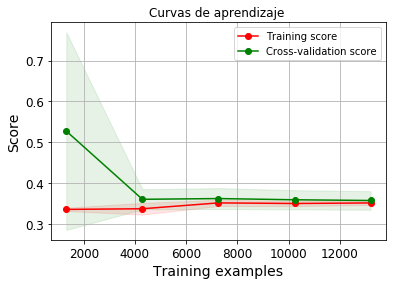

In [65]:
title = "Curvas de aprendizaje "
plt.figure()
plt.title(title)
plt.xlabel("Training examples")
plt.ylabel("Score")

#Validación cruzada para pintar las curvas de entrenamiento y validación e incertidumbre   
train_sizes_lin_reg, train_scores_lin_reg, test_scores_lin_reg= \
    learning_curve(lin_reg, housing_prepared, housing_labels,
                   scoring="neg_mean_squared_error", cv=5)

train_scores_mean_lin_reg= abs(np.mean(train_scores_lin_reg, axis=1))
train_scores_std_lin_reg = abs(np.std(train_scores_lin_reg, axis=1))
test_scores_mean_lin_reg =abs( np.mean(test_scores_lin_reg, axis=1))
test_scores_std_lin_reg =abs( np.std(test_scores_lin_reg, axis=1))


plt.grid()
plt.fill_between(train_sizes_lin_reg, train_scores_mean_lin_reg - train_scores_std_lin_reg,
                 train_scores_mean_lin_reg + train_scores_std_lin_reg, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_lin_reg, test_scores_mean_lin_reg - test_scores_std_lin_reg,
                 test_scores_mean_lin_reg + test_scores_std_lin_reg, alpha=0.1, color="g")

plt.plot(train_sizes_lin_reg, train_scores_mean_lin_reg, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_lin_reg, test_scores_mean_lin_reg, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")


# Regresión de Ridge 

Regresión de Ridge La regresión lineal regular tiene la forma de: J (theta) = MSE (theta) La regresión de Ridge aplica un término de regularización proporcional al cuadrado de la norma l2 de los pesos de las características (sin incluir la intersección). 

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

param_grid_ridgeReg={ "alpha": [0.1,1,60,200, 1000]}

ridgeReg = Ridge(alpha=10)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_ridgeReg = GridSearchCV(ridgeReg, param_grid_ridgeReg, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search_ridgeReg.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 1, 60, 200, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Text(0, 0.5, 'Score')

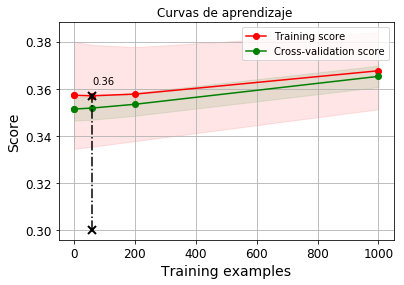

In [67]:
cvres_ridgeReg = grid_search_ridgeReg.cv_results_    
testscores_mean_ridgeReg =abs(cvres_ridgeReg["mean_test_score"])
testscores_sd_ridgeReg = abs(cvres_ridgeReg['std_test_score'])

trainscores_mean_ridgeReg =abs(cvres_ridgeReg['mean_train_score'])
trainscores_sd_ridgeReg = abs(cvres_ridgeReg[ 'std_train_score'])



X_axis_ridgeReg = np.array(cvres_ridgeReg['param_alpha'].data, dtype=float)
plt.fill_between(X_axis_ridgeReg, testscores_mean_ridgeReg - testscores_sd_ridgeReg,
                        testscores_mean_ridgeReg + testscores_sd_ridgeReg,alpha=0.1,color="r")    
plt.plot(X_axis_ridgeReg, testscores_mean_ridgeReg, 'o-', color="r",
         label="Training score")

plt.fill_between(X_axis_ridgeReg, trainscores_mean_ridgeReg - trainscores_sd_ridgeReg,
                 trainscores_mean_ridgeReg + trainscores_sd_ridgeReg, alpha=0.1, color="g")

plt.plot(X_axis_ridgeReg, trainscores_mean_ridgeReg, 'o-', color="g",
         label="Cross-validation score")

X_best_params_ridgeReg=grid_search_ridgeReg.best_params_
X_alpha_ridgeReg = cvres_ridgeReg['param_alpha'].data
plt.plot([X_best_params_ridgeReg.get("alpha"), ] * 2, [0.3, abs(testscores_mean_ridgeReg[np.where(X_alpha_ridgeReg == X_best_params_ridgeReg.get("alpha"))])],
         linestyle='-.', color='k', marker='x', markeredgewidth=2, ms=8)

plt.annotate("%0.2f" % abs(testscores_mean_ridgeReg[np.where(X_alpha_ridgeReg == X_best_params_ridgeReg.get("alpha") )]),
             (X_best_params_ridgeReg.get("alpha") , abs(testscores_mean_ridgeReg[np.where(X_alpha_ridgeReg == X_best_params_ridgeReg.get("alpha") )]+ 0.005)))

plt.grid()
plt.legend(loc="best") 
title = "Curvas de aprendizaje "
plt.title(title)
plt.xlabel("Training examples")
plt.ylabel("Score")

Los mejores hyperparámetros encontrados:

In [68]:
grid_search_ridgeReg.best_params_

{'alpha': 60}

In [69]:
grid_search_ridgeReg.best_estimator_

Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [70]:
for mean_score, params in zip(cvres_ridgeReg["mean_test_score"], cvres_ridgeReg["params"]):
    print(np.sqrt(-mean_score), params)

0.5976381766006605 {'alpha': 0.1}
0.597640070905186 {'alpha': 1}
0.5974792791805015 {'alpha': 60}
0.5980621747682655 {'alpha': 200}
0.6062985337118676 {'alpha': 1000}


# Lasso Regression
La ventaja de la regresión de Lazo sobre la rigida se encuentra en la forma de diamante del contorno de la penalización de la norma l1, lo que hace que algunas de las tetas se eliminen (se establezcan en 0) rápidamente. Esto significa que la regresión Lasso puede realizar la selección automática de características, cuando la regresión rigida no puede.

In [71]:
from sklearn.linear_model import Lasso

param_grid_Lasso={ "alpha": [0.001,0.009,0.02,0.3,2,4]}
ridLasso = Lasso(alpha=2)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_ridLasso = GridSearchCV(ridLasso, param_grid_Lasso, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search_ridLasso.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=2, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.001, 0.009, 0.02, 0.3, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Text(0, 0.5, 'Score')

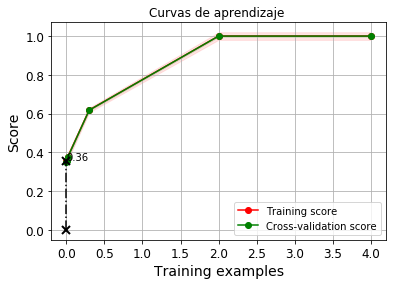

In [72]:
from sklearn.linear_model import Lasso

cvres_ridLasso = grid_search_ridLasso.cv_results_    
testscores_mean_ridLasso =abs(cvres_ridLasso["mean_test_score"])
testscores_sd_ridLasso = abs(cvres_ridLasso['std_test_score'])

trainscores_mean_ridLasso =abs(cvres_ridLasso['mean_train_score'])
trainscores_sd_ridLasso = abs(cvres_ridLasso[ 'std_train_score'])

X_axis_ridLasso = np.array(cvres_ridLasso['param_alpha'].data, dtype=float)

plt.fill_between(X_axis_ridLasso, testscores_mean_ridLasso - testscores_sd_ridLasso,
                        testscores_mean_ridLasso + testscores_sd_ridLasso,alpha=0.1,color="r")   

plt.plot(X_axis_ridLasso, testscores_mean_ridLasso, 'o-', color="r",
         label="Training score")

plt.fill_between(X_axis_ridLasso, trainscores_mean_ridLasso - trainscores_sd_ridLasso,
                 trainscores_mean_ridLasso + trainscores_sd_ridLasso, alpha=0.1, color="g")

plt.plot(X_axis_ridLasso, trainscores_mean_ridLasso, 'o-', color="g",
         label="Cross-validation score")

X_best_params_ridLasso=grid_search_ridLasso.best_params_

X_alpha_ridLasso = cvres_ridLasso['param_alpha'].data

plt.plot([X_best_params_ridLasso.get("alpha"), ] * 2, [0, abs(testscores_mean_ridLasso[np.where(X_alpha_ridLasso == X_best_params_ridLasso.get("alpha"))])],
         linestyle='-.', color='k', marker='x', markeredgewidth=2, ms=8)

plt.annotate("%0.2f" % abs(testscores_mean_ridLasso[np.where(X_alpha_ridLasso == X_best_params_ridLasso.get("alpha"))]),
             (X_best_params_ridLasso.get("alpha"), abs(testscores_mean_ridLasso[np.where(X_alpha_ridLasso == X_best_params_ridLasso.get("alpha"))]+ 0.005)))

plt.legend(loc="best") 


plt.grid()
plt.legend(loc="best") 
title = "Curvas de aprendizaje "
plt.title(title)
plt.xlabel("Training examples")
plt.ylabel("Score")


Los mejores hyperparámetros encontrados:

In [73]:
grid_search_ridLasso.best_params_

{'alpha': 0.001}

In [74]:
grid_search_ridLasso.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [75]:
for mean_score, params in zip(cvres_ridLasso["mean_test_score"], cvres_ridLasso["params"]):
    print(np.sqrt(-mean_score), params)

0.5973617814215421 {'alpha': 0.001}
0.6003278583868545 {'alpha': 0.009}
0.6150111373908 {'alpha': 0.02}
0.7862110952194472 {'alpha': 0.3}
1.0001162162885655 {'alpha': 2}
1.0001162162885655 {'alpha': 4}


# Elastic Net
La red elástica está en algún lugar entre la regresión de la cresta y la regresión del lazo

In [76]:
from sklearn.linear_model import ElasticNet

alpha = np.array([0.0001,0.1,10])
l1_ratio = np.array([2,20,50])

param_grid_ElasticNet= [
    # try 12 (3×4) combinations of hyperparameters
    {"alpha": alpha,"l1_ratio": l1_ratio}
  ]


ridElastic = ElasticNet(alpha = 0.1, l1_ratio =0.1)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_ridElastic = GridSearchCV(ridElastic, param_grid_ElasticNet, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search_ridElastic.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([1.e-04, 1.e-01, 1.e+01]), 'l1_ratio': array([ 2, 20, 50])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Text(50, [[0.36156298]], '0.3566')

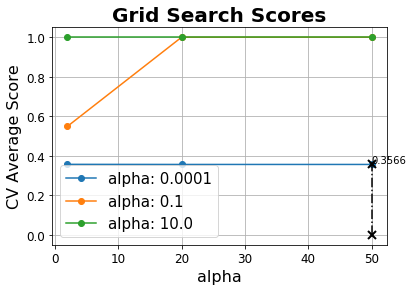

In [77]:
cvres_ridElastic = grid_search_ridElastic.cv_results_ 

X_best_params_ridElastic=grid_search_ridElastic.best_params_
testscores_mean_ridElastic = abs(cvres_ridElastic["mean_test_score"])
testscores_mean_ridElastic = np.array(testscores_mean_ridElastic).reshape(len(l1_ratio),len(alpha))

testscores_sd_ridElastic  =  abs(cvres_ridElastic['std_test_score'])
testscores_sd_ridElastic = np.array(testscores_sd_ridElastic).reshape(len(l1_ratio),len(alpha))

# Plot Grid search scores
_, ax = plt.subplots(1,1)

# Param1 is the X-axis, Param 2 is represented as a different curve (color line)"l1_ratio" "alpha"
for idx, val in enumerate(alpha):
    ax.plot(l1_ratio, testscores_mean_ridElastic[idx,:], '-o', label= 'alpha' + ': ' + str(val)) 

ax.plot([X_best_params_ridElastic.get("l1_ratio"), ] * 2, [0, abs(testscores_mean_ridElastic[np.where(alpha == X_best_params_ridElastic.get("alpha")),np.where(l1_ratio == X_best_params_ridElastic.get("l1_ratio"))])],
        linestyle='-.', color='k', marker='x', markeredgewidth=2, ms=8)  
ax.grid()
ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
ax.set_xlabel('alpha', fontsize=16)
ax.set_ylabel('CV Average Score', fontsize=16)
ax.legend(loc="best", fontsize=15)
ax.annotate("%0.4f" % abs(testscores_mean_ridElastic[np.where(alpha == X_best_params_ridElastic.get("alpha")),np.where(l1_ratio == X_best_params_ridElastic.get("l1_ratio"))]),
             (X_best_params_ridElastic.get("l1_ratio"), abs(testscores_mean_ridElastic[np.where(alpha == X_best_params_ridElastic.get("alpha")),np.where(l1_ratio == X_best_params_ridElastic.get("l1_ratio"))] + 0.005)))

In [78]:
grid_search_ridElastic.best_params_

{'alpha': 0.0001, 'l1_ratio': 50}

In [79]:
grid_search_ridElastic.best_estimator_

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=50,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [80]:
for mean_score, params in zip(cvres_ridElastic["mean_test_score"],cvres_ridElastic["params"]):
    print(np.sqrt(-mean_score), params)  

0.5976008032623901 {'alpha': 0.0001, 'l1_ratio': 2}
0.5971470302019725 {'alpha': 0.0001, 'l1_ratio': 20}
0.5971289439757493 {'alpha': 0.0001, 'l1_ratio': 50}
0.7411386631737799 {'alpha': 0.1, 'l1_ratio': 2}
1.0001162162885655 {'alpha': 0.1, 'l1_ratio': 20}
1.0001162162885655 {'alpha': 0.1, 'l1_ratio': 50}
1.0001162162885655 {'alpha': 10.0, 'l1_ratio': 2}
1.0001162162885655 {'alpha': 10.0, 'l1_ratio': 20}
1.0001162162885655 {'alpha': 10.0, 'l1_ratio': 50}


# KernelRidge rbf

combina Kernel ridge regression(mínimos cuadrados lineales con la regularización de la norma l2) con el truco del kernel. Así aprende una función lineal en el espacio inducido por el kernel respectivo y los datos. Para los núcleos no lineales, esto corresponde a una función no lineal en el espacio original.

Nota: al tener tantos dato el proceso podría tardar un tiempo considerable si no se paraleliza

In [81]:
from sklearn.kernel_ridge import KernelRidge

gamma = np.array([0.00001,0.0001,0.01,0.1])
param_grid_kernel = [ {"gamma": gamma}]

grid_search_KernelRidge= GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),param_grid_kernel, cv=5,
                                         scoring='neg_mean_squared_error', return_train_score=True)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_KernelRidge.fit(housing_prepared[:6500,:], housing_labels[:6500])


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=0.1, kernel='rbf',
      kernel_params=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'gamma': array([1.e-05, 1.e-04, 1.e-02, 1.e-01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

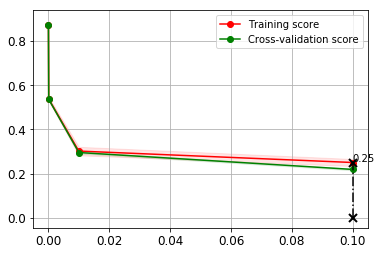

In [82]:
cvres_KernelRidge = grid_search_KernelRidge.cv_results_     
testscores_mean_KernelRidge =abs(cvres_KernelRidge["mean_test_score"])
testscores_sd_KernelRidge = abs(cvres_KernelRidge['std_test_score'])

trainscores_mean_KernelRidge =abs(cvres_KernelRidge['mean_train_score'])
trainscores_sd_KernelRidge = abs(cvres_KernelRidge[ 'std_train_score'])



X_axis_KernelRidge = np.array(cvres_KernelRidge['param_gamma'].data, dtype=float)
plt.fill_between(X_axis_KernelRidge, testscores_mean_KernelRidge - testscores_sd_KernelRidge,
                        testscores_mean_KernelRidge + testscores_sd_KernelRidge,alpha=0.1,color="r")    
plt.plot(X_axis_KernelRidge, testscores_mean_KernelRidge, 'o-', color="r",
         label="Training score")

plt.fill_between(X_axis_KernelRidge, trainscores_mean_KernelRidge - trainscores_sd_KernelRidge,
                 trainscores_mean_KernelRidge + trainscores_sd_KernelRidge, alpha=0.1, color="g")

plt.plot(X_axis_KernelRidge, trainscores_mean_KernelRidge, 'o-', color="g",
         label="Cross-validation score")

X_best_params_KernelRidge=grid_search_KernelRidge.best_params_
X_alpha_KernelRidge = cvres_KernelRidge['param_gamma'].data

plt.plot([X_best_params_KernelRidge.get("gamma"), ] * 2, [0, abs(testscores_mean_KernelRidge[np.where(X_alpha_KernelRidge == X_best_params_KernelRidge.get("gamma"))])],
         linestyle='-.', color='k', marker='x', markeredgewidth=2, ms=8)

plt.annotate("%0.2f" % abs(testscores_mean_KernelRidge[np.where(X_alpha_KernelRidge == X_best_params_KernelRidge.get("gamma"))]),
             (X_best_params_KernelRidge.get("gamma"), abs(testscores_mean_KernelRidge[np.where(X_alpha_KernelRidge == X_best_params_KernelRidge.get("gamma"))]+ 0.005)))

plt.legend(loc="best") 
plt.grid()


In [83]:
grid_search_KernelRidge.best_params_


{'gamma': 0.1}

In [84]:
grid_search_KernelRidge.best_estimator_


KernelRidge(alpha=1, coef0=1, degree=3, gamma=0.1, kernel='rbf',
      kernel_params=None)

In [85]:
for mean_score, params in zip(cvres_KernelRidge["mean_test_score"],cvres_KernelRidge["params"]):
    print(np.sqrt(-mean_score), params)


0.9336459471989126 {'gamma': 1e-05}
0.7333696288244816 {'gamma': 0.0001}
0.5498060363467231 {'gamma': 0.01}
0.5005893095760681 {'gamma': 0.1}


# Kernel Ridge linear

combina Kernel ridge regression(mínimos cuadrados lineales con la regularización de la norma l2) con el truco del kernel. Así aprende una función lineal en el espacio inducido por el kernel respectivo y los datos. Para los núcleos no lineales, esto corresponde a una función no lineal en el espacio original.


In [86]:
from sklearn.kernel_ridge import KernelRidge
ridKernelRidge_l =KernelRidge(kernel='linear')
ridKernelRidge_l.fit(housing_prepared[:8500,:],housing_labels[:8500])


KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)

In [87]:
KernelRidge_l = cross_val_score(ridKernelRidge_l , housing_prepared[:8500,:],housing_labels[:8500],
                         scoring="neg_mean_squared_error", cv=5) #scikitlearn trabaja con función util (mayor mejor) no función de costo (menor mejor)
tree_rmse_scores_KernelRidge_l = np.sqrt(-KernelRidge_l)


In [88]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores_KernelRidge_l)


Scores: [0.57718364 0.58853483 0.61287329 0.63872744 0.60502626]
Mean: 0.6044690911020045
Standard deviation: 0.021180049210825853


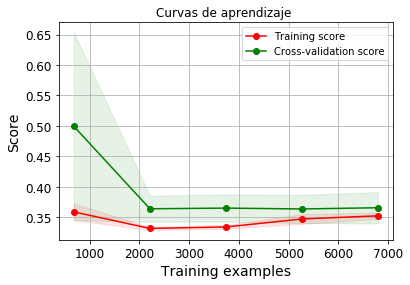

In [89]:
title = "Curvas de aprendizaje "
plt.figure()
plt.title(title)
plt.xlabel("Training examples")
plt.ylabel("Score")

    
train_sizes_KernelRidge_l, train_scores_KernelRidge_l, test_scores_KernelRidge_l = \
    learning_curve(ridKernelRidge_l, housing_prepared[:8500,:],housing_labels[:8500],
                   scoring="neg_mean_squared_error", cv=5)

train_scores_mean_KernelRidge_l = abs(np.mean(train_scores_KernelRidge_l, axis=1))
train_scores_std_KernelRidge_l = abs(np.std(train_scores_KernelRidge_l, axis=1))
test_scores_mean_KernelRidge_l = abs(np.mean(test_scores_KernelRidge_l, axis=1))
test_scores_std_KernelRidge_l = abs(np.std(test_scores_KernelRidge_l, axis=1))
plt.grid()
plt.fill_between(train_sizes_KernelRidge_l, train_scores_mean_KernelRidge_l - train_scores_std_KernelRidge_l,
                 train_scores_mean_KernelRidge_l + train_scores_std_KernelRidge_l, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_KernelRidge_l, test_scores_mean_KernelRidge_l - test_scores_std_KernelRidge_l,
                 test_scores_mean_KernelRidge_l + test_scores_std_KernelRidge_l, alpha=0.1, color="g")

plt.plot(train_sizes_KernelRidge_l, train_scores_mean_KernelRidge_l, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_KernelRidge_l, test_scores_mean_KernelRidge_l, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best") 



# Bayesian Ridge Regression

estima un modelo probabilístico del problema de regresión como se describe anteriormente. El previo para el coeficiente. w Es dado por un gaussiano esférico

In [90]:
from sklearn.linear_model import BayesianRidge

ridBayesianRidge =BayesianRidge(compute_score=True)
ridBayesianRidge.fit(housing_prepared,housing_labels)



BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [91]:
BayesianRidge = cross_val_score(ridBayesianRidge ,housing_prepared,housing_labels,
                         scoring="neg_mean_squared_error", cv=5) #scikitlearn trabaja con función util (mayor mejor) no función de costo (menor mejor)
tree_rmse_scores_BayesianRidge = np.sqrt(-BayesianRidge)

In [92]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores_BayesianRidge)

Scores: [0.57824732 0.62755638 0.60185374 0.5759426  0.60323887]
Mean: 0.597367782879348
Standard deviation: 0.0189239299714158


Text(0.5, 0, 'Iterations')

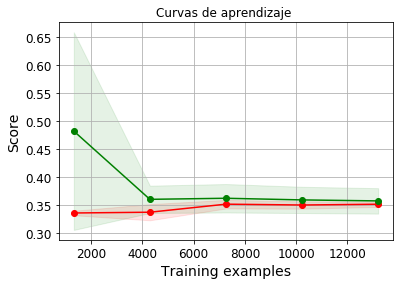

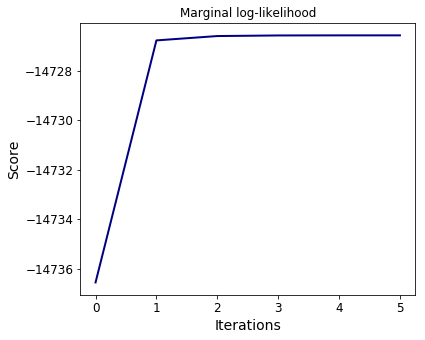

In [93]:
title = "Curvas de aprendizaje "
plt.figure()
plt.title(title)
plt.xlabel("Training examples")
plt.ylabel("Score")
    
train_sizes_BayesianRidge, train_scores_BayesianRidge, test_scores_BayesianRidge = \
    learning_curve(ridBayesianRidge, housing_prepared,housing_labels,
                   scoring="neg_mean_squared_error", cv=5)

train_scores_mean_BayesianRidge =abs( np.mean(train_scores_BayesianRidge, axis=1))
train_scores_std_BayesianRidge = abs(np.std(train_scores_BayesianRidge, axis=1))
test_scores_mean_BayesianRidge = abs(np.mean(test_scores_BayesianRidge, axis=1))
test_scores_std_BayesianRidge = abs(np.std(test_scores_BayesianRidge, axis=1))
plt.grid()
plt.fill_between(train_sizes_BayesianRidge, train_scores_mean_BayesianRidge - train_scores_std_BayesianRidge,
                 train_scores_mean_BayesianRidge + train_scores_std_BayesianRidge, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_BayesianRidge, test_scores_mean_BayesianRidge - test_scores_std_BayesianRidge,
                 test_scores_mean_BayesianRidge + test_scores_std_BayesianRidge, alpha=0.1, color="g")

plt.plot(train_sizes_BayesianRidge, train_scores_mean_BayesianRidge, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_BayesianRidge, test_scores_mean_BayesianRidge, 'o-', color="g",
         label="Cross-validation score")



plt.figure(figsize=(6, 5))
plt.title("Marginal log-likelihood")
plt.plot(ridBayesianRidge.scores_, color='navy', linewidth=2)
plt.ylabel("Score")
plt.xlabel("Iterations")

# Automatic Relevance Determination Regression (ARD)

Ajuste los pesos de un modelo de regresión, utilizando un ARD anterior. Se asume que los pesos del modelo de regresión están en distribuciones gaussianas. También estimar los parámetros lambda (precisiones de las distribuciones de los pesos) y alfa (precisión de la distribución del ruido). La estimación se realiza mediante un procedimiento iterativo (Maximización de la evidencia).

In [97]:
from sklearn.linear_model import ARDRegression

threshold_lambda = np.array([0.001,10,12])
param_grid_ARD = [ {"threshold_lambda": threshold_lambda}]

grid_search_ARD= GridSearchCV(ARDRegression(threshold_lambda=1e5),param_grid_ARD, cv=5,
                                         scoring='neg_mean_squared_error', return_train_score=True)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_ARD.fit(housing_prepared[:2500,:],housing_labels[:2500])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, threshold_lambda=100000.0, tol=0.001,
       verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'threshold_lambda': array([1.0e-03, 1.0e+01, 1.2e+01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Text(0, 0.5, 'Score')

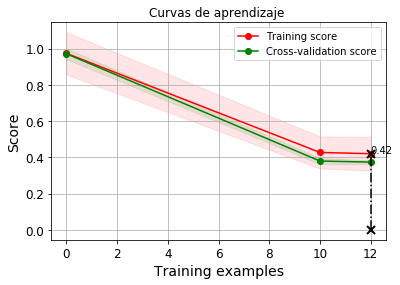

In [98]:
cvres_ARD = grid_search_ARD.cv_results_    
testscores_mean_ARD =abs(cvres_ARD["mean_test_score"])
testscores_sd_ARD = abs(cvres_ARD['std_test_score'])

trainscores_mean_ARD =abs(cvres_ARD['mean_train_score'])
trainscores_sd_ARD = abs(cvres_ARD[ 'std_train_score'])

X_axis_ARD= np.array(cvres_ARD['param_threshold_lambda'].data, dtype=float)
plt.fill_between(X_axis_ARD, testscores_mean_ARD- testscores_sd_ARD,
                        testscores_mean_ARD + testscores_sd_ARD,alpha=0.1,color="r")    

plt.plot(X_axis_ARD, testscores_mean_ARD, 'o-', color="r",label="Training score")

plt.fill_between(X_axis_ARD, trainscores_mean_ARD - trainscores_sd_ARD,
                 trainscores_mean_ARD + trainscores_sd_ARD, alpha=0.1, color="g")

plt.plot(X_axis_ARD, trainscores_mean_ARD, 'o-', color="g",
         label="Cross-validation score")

X_best_params_ARD=grid_search_ARD.best_params_
X_alpha_ARD = cvres_ARD['param_threshold_lambda'].data

plt.plot([X_best_params_ARD.get('threshold_lambda'), ] * 2, [0, abs(testscores_mean_ARD[np.where(X_alpha_ARD == X_best_params_ARD.get('threshold_lambda'))])],
         linestyle='-.', color='k', marker='x', markeredgewidth=2, ms=8)

plt.annotate("%0.2f" % abs(testscores_mean_ARD[np.where(X_alpha_ARD== X_best_params_ARD.get('threshold_lambda'))]),
             (X_best_params_ARD.get('threshold_lambda'), abs(testscores_mean_ARD[np.where(X_alpha_ARD == X_best_params_ARD.get('threshold_lambda'))]+ 0.005)))

plt.legend(loc="best") 
plt.grid()
plt.legend(loc="best") 
title = "Curvas de aprendizaje "
plt.title(title)
plt.xlabel("Training examples")
plt.ylabel("Score")

In [99]:
grid_search_ARD.best_params_

{'threshold_lambda': 12.0}

In [100]:
for mean_score, params in zip(cvres_ARD["mean_test_score"],cvres_ARD["params"]):
    print(np.sqrt(-mean_score), params)

0.9865906049077295 {'threshold_lambda': 0.001}
0.653430231703865 {'threshold_lambda': 10.0}
0.6483605996467904 {'threshold_lambda': 12.0}


# Seleccionar un modelo Sintonizado con los mejores parámetros

In [101]:

#linear regression
test_rmse_scores_lin_reg = np.sqrt(test_scores_mean_lin_reg )
#Regresión de Ridge
test_score_ridgeReg=np.array([abs(cvres_ridgeReg['split0_test_score']),abs(cvres_ridgeReg['split1_test_score']),
                              abs(cvres_ridgeReg['split2_test_score']),abs(cvres_ridgeReg['split3_test_score']),
                              abs(cvres_ridgeReg['split4_test_score'])])
params_optimo_ridgeReg=np.where(X_alpha_ridgeReg == X_best_params_ridgeReg.get("alpha"))
test_rmse_scores_ridgeReg=np.sqrt(test_score_ridgeReg[0:,np.int(params_optimo_ridgeReg[-1])])

#Regresión de Lasso
test_score_Lasso=np.array([abs(cvres_ridLasso['split0_test_score']),abs(cvres_ridLasso['split1_test_score']),
                           abs(cvres_ridLasso['split2_test_score']),abs(cvres_ridLasso['split3_test_score']),
                           abs(cvres_ridLasso['split4_test_score'])])
params_optimo_Lassog=np.where(X_alpha_ridLasso == X_best_params_ridLasso.get("alpha"))
test_rmse_scores_Lassog=np.sqrt(test_score_Lasso[0:,np.int(params_optimo_Lassog[-1])])

#Regresión de Elastic
test_score_Elastic=np.array([abs(cvres_ridElastic['split0_test_score']),abs(cvres_ridElastic['split1_test_score']),
                             abs(cvres_ridElastic['split2_test_score']),abs(cvres_ridElastic['split3_test_score']),
                             abs(cvres_ridElastic['split4_test_score'])])



params_optimo_Elastic=np.where(np.array(cvres_ridElastic['params'])==grid_search_ridElastic.best_params_)
test_rmse_scores_Elastic=np.sqrt(test_score_Elastic[0:,np.int(params_optimo_Elastic[-1])])

#KernelRidge rbf
test_score_KernelRidg=np.array([abs(cvres_KernelRidge['split0_test_score']),abs(cvres_KernelRidge['split1_test_score']),
                                abs(cvres_KernelRidge['split2_test_score']),abs(cvres_KernelRidge['split3_test_score']),
                                abs(cvres_KernelRidge['split4_test_score'])])
params_optimo_KernelRidg=np.where(X_alpha_KernelRidge == X_best_params_KernelRidge.get("gamma"))
test_rmse_scores_KernelRidg=np.sqrt(test_score_KernelRidg[0:,np.int(params_optimo_KernelRidg[-1])])

#Kernel Ridge linear
test_rmse_scores_KernelRidge_l = np.sqrt(test_scores_mean_KernelRidge_l )

#Bayesian Ridge Regression
test_rmse_BayesianRidge=np.sqrt(test_scores_mean_BayesianRidge)


#Automatic Relevance Determination Regression (ARD)

test_score_ARD=np.array([abs(cvres_ARD['split0_test_score']),abs(cvres_ARD['split1_test_score']),
                         abs(cvres_ARD['split2_test_score']),abs(cvres_ARD['split3_test_score']),
                         abs(cvres_ARD['split4_test_score'])])

params_optimo_ARD=np.where(X_alpha_ARD == X_best_params_ARD.get('threshold_lambda'))
test_rmse_scores_ARD=np.sqrt(test_score_ARD[0:,np.int(params_optimo_ARD[-1])])



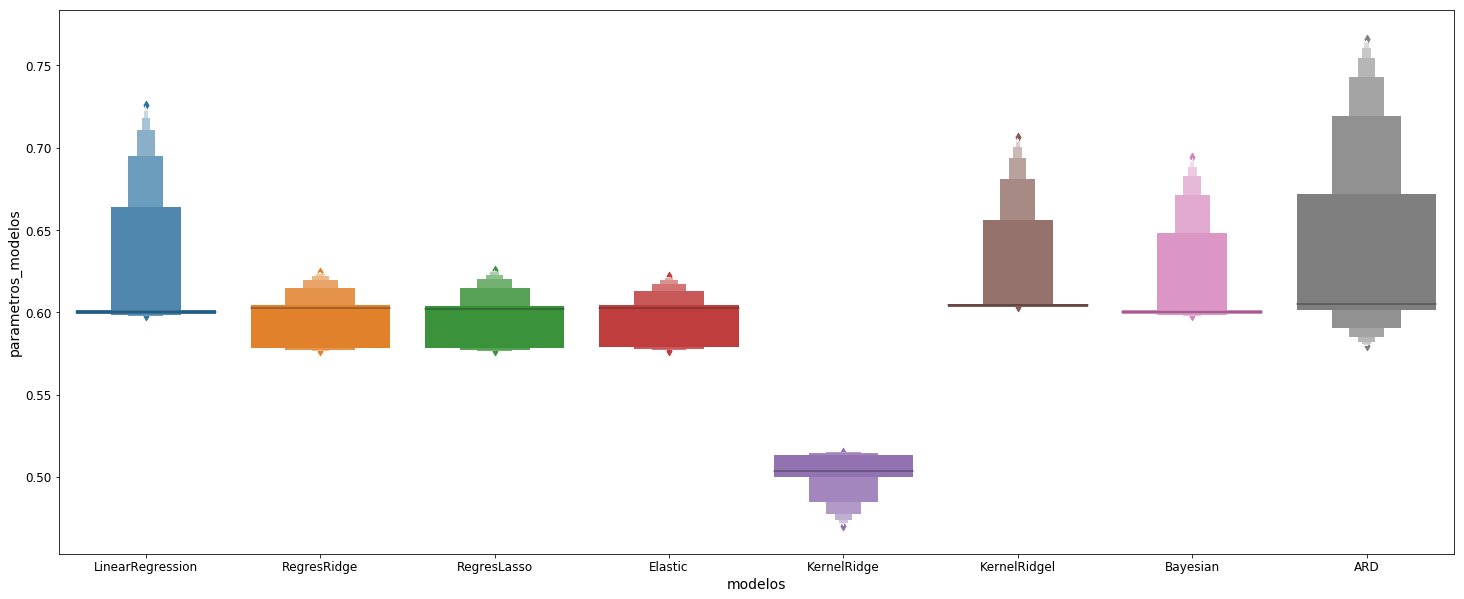

In [103]:
# Función que convierte los datos en el factor de euros
def modelos_name(name):
    # Convert M in value column to millions
    if name == 1.0:
        return 'LinearRegression'
    if name == 2.0:
        return 'RegresRidge'
    if name == 3.0:
        return 'RegresLasso'
    if name == 4.0:
        return 'Elastic'
    if name == 5.0:
        return 'KernelRidge'
    if name == 6.0:
        return 'KernelRidgel'
    if name == 7.0:
        return 'Bayesian'
    if name == 8.0:
        return 'ARD'

#modelos
modelos=np.array([[np.ones(len(test_rmse_scores_lin_reg))], [np.ones(len(test_rmse_scores_ridgeReg))*2], 
                  [np.ones(len(test_rmse_scores_Lassog))*3],[np.ones(len(test_rmse_scores_Elastic))*4],
                  [np.ones(len(test_rmse_scores_KernelRidg))*5],[np.ones(len(test_rmse_scores_KernelRidge_l))*6],
                  [np.ones(len(test_rmse_scores_ARD))*7],[np.ones(len(test_rmse_scores_ARD))*8],
                  
                 ])

modelos=np.reshape(modelos,40)
parametros_modelos=np.array([[test_rmse_scores_lin_reg], [test_rmse_scores_ridgeReg], 
                             [test_rmse_scores_Lassog], [test_rmse_scores_Elastic],
                             [test_rmse_scores_KernelRidg],[test_rmse_scores_KernelRidge_l],
                             [test_rmse_BayesianRidge],[test_rmse_scores_ARD],
                            ])
parametros_modelos=np.reshape(parametros_modelos, 40)

rultados_de_test_train= {'modelos': pd.Series(modelos),                         
                         'parametros_modelos': pd.Series(parametros_modelos)}
                                                         

rultados_de_test_train_table = pd.DataFrame(rultados_de_test_train)
rultados_de_test_train_table['modelos']= rultados_de_test_train_table['modelos'].apply(lambda x:  modelos_name(x) )

plt.figure(figsize=(25,10))
sns.boxenplot(rultados_de_test_train_table['modelos'],rultados_de_test_train_table['parametros_modelos'])



El intervalo de confianza al 95% se puede calcular para el RMSE sobre el conjunto de test:

In [105]:
from sklearn.metrics import mean_squared_error
final_model = grid_search_KernelRidge.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [106]:
final_rmse

235791.28373159113

In [107]:
from scipy import stats

In [108]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
sigma = squared_errors.std()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors))) #https://es.wikipedia.org/wiki/Error_est%C3%A1ndar#Error_est%C3%A1ndar_de_la_media

array([231788.52985139, 239727.21246641])

In [110]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin) #https://es.wikipedia.org/wiki/Distribuci%C3%B3n_t_de_Student


(231788.52985138516, 239727.21246641316)

We could compute the interval manually like this:

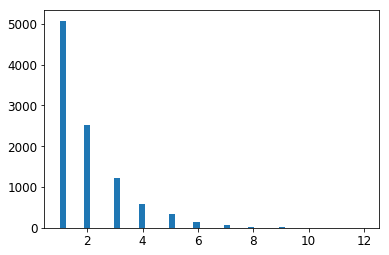

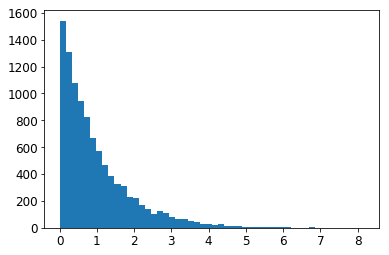

In [114]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()